In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import re

In [7]:
# --- 1. LOAD DATA ---
det_df = pd.read_csv('Data/DET_final_corrected_df.csv')
rag_df = pd.read_csv('Data/RAG_corrected_df.csv')

C:\Users\nicoc\AppData\Local\Temp\ipykernel_17756\3244155999.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby('score_bin')['is_physically_valid'].mean()
C:\Users\nicoc\AppData\Local\Temp\ipykernel_17756\3244155999.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby('score_bin')['is_physically_valid'].mean()


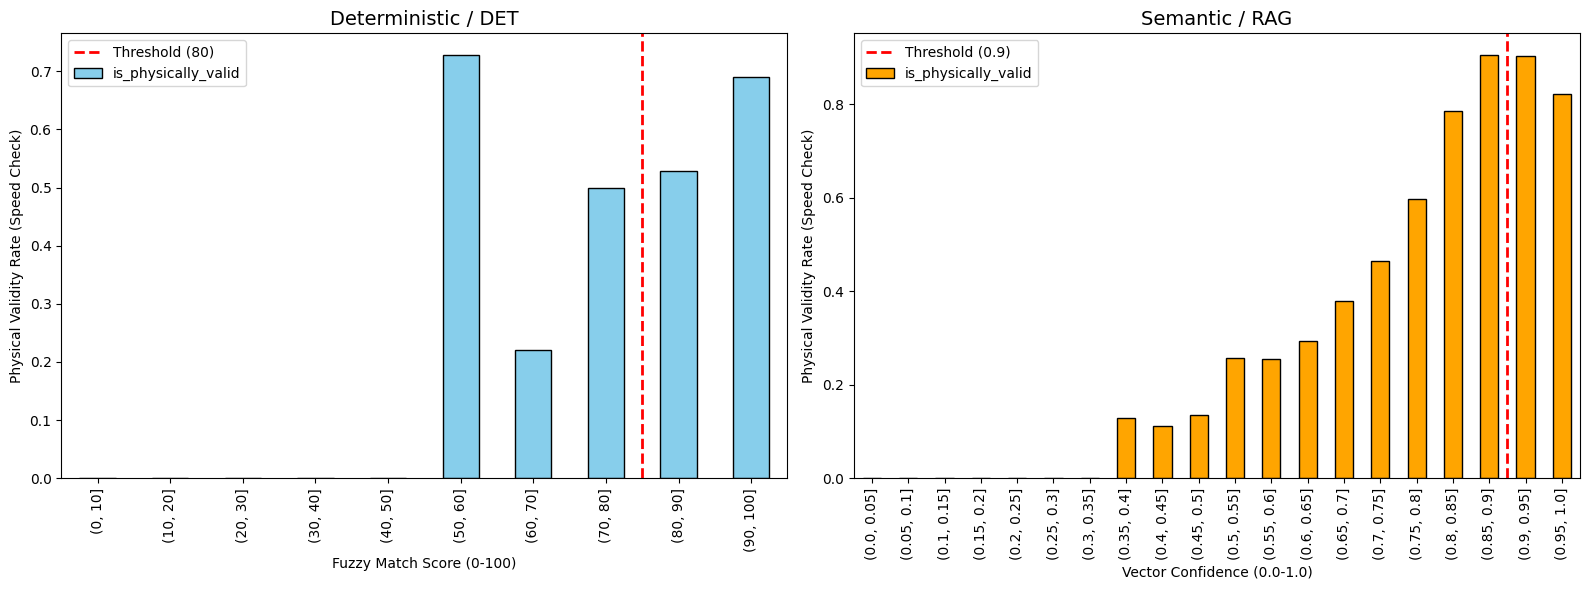

--- FINAL THESIS NUMBERS ---
DET Raw Corrections: 7341
DET Safe Corrections (>80): 6264
Discarded (Noise): 1077
------------------------------
RAG Raw Corrections: 8051
RAG Safe Corrections (>0.9): 1437
Discarded (Hallucinations): 6614


In [51]:
# --- 2. EXTRACT DET SCORES ---
def get_det_score(note):
    # Extracts number from "start_fix(95)"
    if pd.isna(note): return 0
    matches = re.findall(r'\((\d+)\)', str(note))
    if not matches: return 0
    return max([int(m) for m in matches]) # Take the best score of the pair

det_df['confidence_score'] = det_df['note_correction'].apply(get_det_score)

# --- 3. PREPARE RAG SCORES ---
# We use the minimum confidence because the chain is as weak as its weakest link
rag_df['confidence_score'] = rag_df[['rag_start_conf', 'rag_end_conf']].min(axis=1)

# --- 4. THE ANALYSIS: Score vs. "Likelihood of Good Speed" ---
# We assume a "Good Speed" is between 1 and 130 km/h. 
# We check what % of corrections fall in this valid physical range at each score level.

def calculate_validity_rate(df, method):
    # Calculate implied speed
    duration = df['stagedurationmin_raw'].replace(0, np.nan) / 60
    dist = df['corrected_dist_km'].fillna(df['stagelength_raw'])
    speed = dist / duration
    
    df['is_physically_valid'] = speed.between(1, 130) # 1-130 km/h is "Reasonable"
    
    # Group by score bins
    if method == 'DET':
        bins = np.arange(0, 110, 10)
    else:
        bins = np.arange(0, 1.05, 0.05)
        
    df['score_bin'] = pd.cut(df['confidence_score'], bins)
    return df.groupby('score_bin')['is_physically_valid'].mean()

det_validity = calculate_validity_rate(det_df[det_df['validation_status']=='corrected'].copy(), 'DET')
rag_validity = calculate_validity_rate(rag_df[rag_df['llm_verdict']=='corrected'].copy(), 'RAG')

# --- 5. PLOT THE "CLIFFS" ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot DET
det_validity.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Deterministic / DET', fontsize=14)
axes[0].set_xlabel('Fuzzy Match Score (0-100)')
axes[0].set_ylabel('Physical Validity Rate (Speed Check)')
axes[0].axvline(x=7.5, color='red', linestyle='--', linewidth=2, label='Threshold (80)') # approx position
axes[0].legend()

# Plot RAG
rag_validity.plot(kind='bar', ax=axes[1], color='orange', edgecolor='black')
axes[1].set_title('Semantic / RAG', fontsize=14)
axes[1].set_xlabel('Vector Confidence (0.0-1.0)')
axes[1].set_ylabel('Physical Validity Rate (Speed Check)')
axes[1].axvline(x=17.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.9)') # approx position
axes[1].legend()

plt.tight_layout()
plt.show()

# --- 6. CALCULATE FINAL "QUALITY-ADJUSTED" NUMBERS ---
det_safe = len(det_df[(det_df['validation_status']=='corrected') & (det_df['confidence_score'] >= 80)])
rag_safe = len(rag_df[(rag_df['llm_verdict']=='corrected') & (rag_df['confidence_score'] >= 0.90)])

print(f"--- FINAL THESIS NUMBERS ---")
print(f"DET Raw Corrections: {len(det_df[det_df['validation_status']=='corrected'])}")
print(f"DET Safe Corrections (>80): {det_safe}")
print(f"Discarded (Noise): {len(det_df[det_df['validation_status']=='corrected']) - det_safe}")
print("-" * 30)
print(f"RAG Raw Corrections: {len(rag_df[rag_df['llm_verdict']=='corrected'])}")
print(f"RAG Safe Corrections (>0.9): {rag_safe}")
print(f"Discarded (Hallucinations): {len(rag_df[rag_df['llm_verdict']=='corrected']) - rag_safe}")

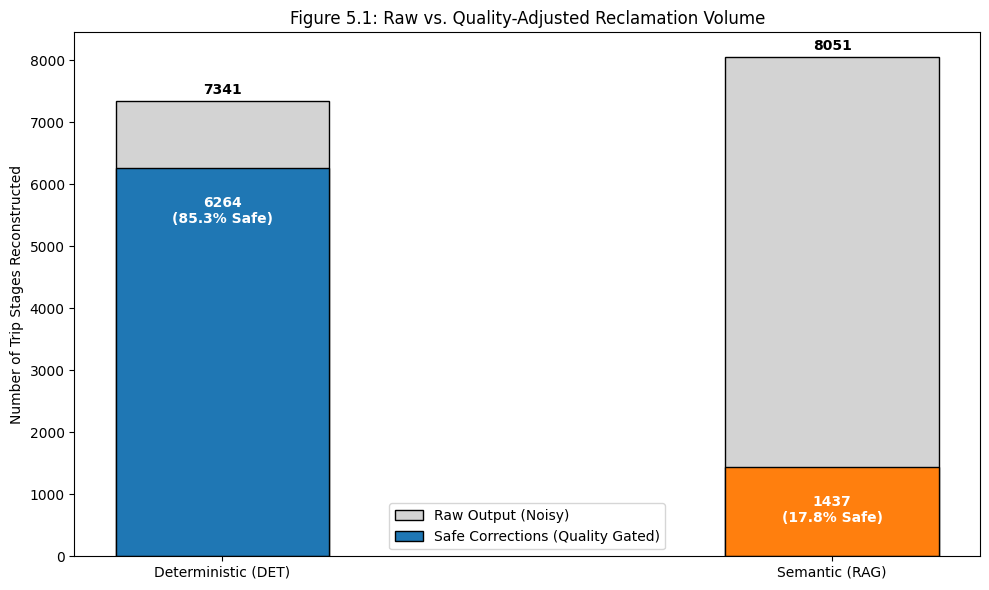

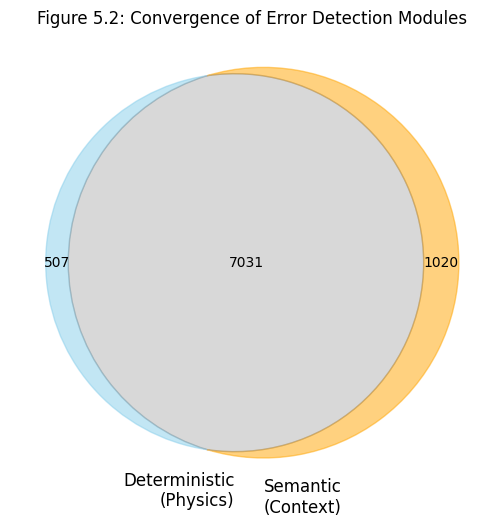

In [13]:

# --- DATA FROM YOUR RESULTS ---
# DET
det_raw = 7341
det_safe = 6264  # (>80 score)

# RAG
rag_raw = 8051
rag_safe = 1437  # (>0.9 conf)

# OVERLAP (From comparison analysis)
# Approximate numbers based on your logs
both_found = 7031
det_only = 507
rag_only = 1020

# --- FIGURE 5.1: Quality-Adjusted Reclamation ---
fig, ax = plt.subplots(figsize=(10, 6))

labels = ['Deterministic (DET)', 'Semantic (RAG)']
raw_values = [det_raw, rag_raw]
safe_values = [det_safe, rag_safe]

x = np.arange(len(labels))
width = 0.35

# Plot Raw (Light Color)
rects1 = ax.bar(x, raw_values, width, label='Raw Output (Noisy)', color='lightgray', edgecolor='black')

# Plot Safe (Dark Color) - Overlay or Side-by-Side? Overlay looks like "Filtering"
rects2 = ax.bar(x, safe_values, width, label='Safe Corrections (Quality Gated)', color=['#1f77b4', '#ff7f0e'], edgecolor='black')

ax.set_ylabel('Number of Trip Stages Reconstructed')
ax.set_title('Figure 5.1: Raw vs. Quality-Adjusted Reclamation Volume')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add labels
def autolabel(rects, is_safe=False):
    for rect in rects:
        height = rect.get_height()
        label = f"{height}"
        if is_safe:
            percentage = height / rects1[rects.index(rect)].get_height()
            label += f"\n({percentage:.1%} Safe)"
        ax.annotate(label,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3 if not is_safe else -20),
                    textcoords="offset points",
                    ha='center', va='bottom' if not is_safe else 'top',
                    color='black' if not is_safe else 'white',
                    fontweight='bold')

autolabel(rects1)
autolabel(rects2, is_safe=True)

plt.tight_layout()
plt.show()

# --- FIGURE 5.2: The Error Overlap ---
plt.figure(figsize=(8, 6))
v = venn2(subsets=(det_only, rag_only, both_found), 
          set_labels=('Deterministic\n(Physics)', 'Semantic\n(Context)'))

# Style
v.get_patch_by_id('10').set_color('skyblue')
v.get_patch_by_id('01').set_color('orange')
v.get_patch_by_id('11').set_color('gray')
v.get_patch_by_id('10').set_alpha(0.5)
v.get_patch_by_id('01').set_alpha(0.5)
v.get_patch_by_id('11').set_alpha(0.3)

plt.title("Figure 5.2: Convergence of Error Detection Modules")
plt.show()

C:\Users\nicoc\AppData\Local\Temp\ipykernel_17756\3711702296.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  validity_rates = plot_df.groupby('score_bin')['is_valid'].mean() * 100


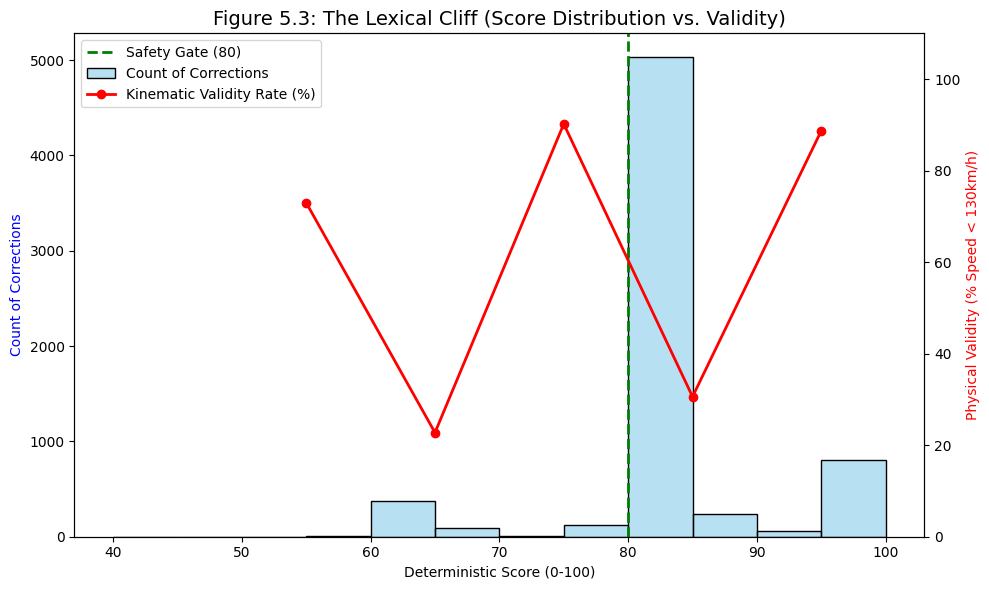

In [15]:
# 1. SCORE EXTRACTION
def extract_det_score(note):
    if pd.isna(note): return np.nan
    matches = re.findall(r'\((\d+)\)', str(note))
    if not matches: return np.nan
    return sum([int(m) for m in matches]) / len(matches)

# Work on corrected rows only
plot_df = det_df[det_df['validation_status'] == 'corrected'].copy()
plot_df['det_score'] = plot_df['note_correction'].apply(extract_det_score)

# 2. VALIDITY CALCULATION (For the Line Plot)
# Valid if Speed < 130 km/h (Arbitrary "Impossible" cut-off for the graph)
def is_valid_speed(row):
    try:
        dist = row['corrected_dist_km']
        time = row['stagedurationmin_raw'] / 60
        if time <= 0 or pd.isna(dist): return False
        speed = dist / time
        return 0 < speed < 130
    except:
        return False

plot_df['is_valid'] = plot_df.apply(is_valid_speed, axis=1)

# Bin the scores to calculate rates
plot_df['score_bin'] = pd.cut(plot_df['det_score'], bins=range(0, 110, 10), labels=range(5, 105, 10))
validity_rates = plot_df.groupby('score_bin')['is_valid'].mean() * 100

# 3. PLOTTING
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary Axis: Histogram
sns.histplot(data=plot_df, x='det_score', bins=range(40, 105, 5), 
             color='skyblue', alpha=0.6, label='Count of Corrections', ax=ax1)
ax1.set_ylabel('Count of Corrections', color='blue')
ax1.set_xlabel('Deterministic Score (0-100)')

# Secondary Axis: Validity Line
ax2 = ax1.twinx()
ax2.plot(validity_rates.index.astype(int), validity_rates.values, 
         color='red', marker='o', linewidth=2, label='Kinematic Validity Rate (%)')
ax2.set_ylabel('Physical Validity (% Speed < 130km/h)', color='red')
ax2.set_ylim(0, 110)

# Threshold Line
ax1.axvline(x=80, color='green', linestyle='--', linewidth=2, label='Safety Gate (80)')

# Title & Legend
plt.title('Figure 5.3: The Lexical Cliff (Score Distribution vs. Validity)', fontsize=14)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

Original Count: 7341
Filtered Count (<= 100km): 5809
Outliers Removed: 1532


C:\Users\nicoc\AppData\Local\Temp\ipykernel_17756\2629435581.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score_bin', y='dist_delta', data=df_clean, palette="Blues")


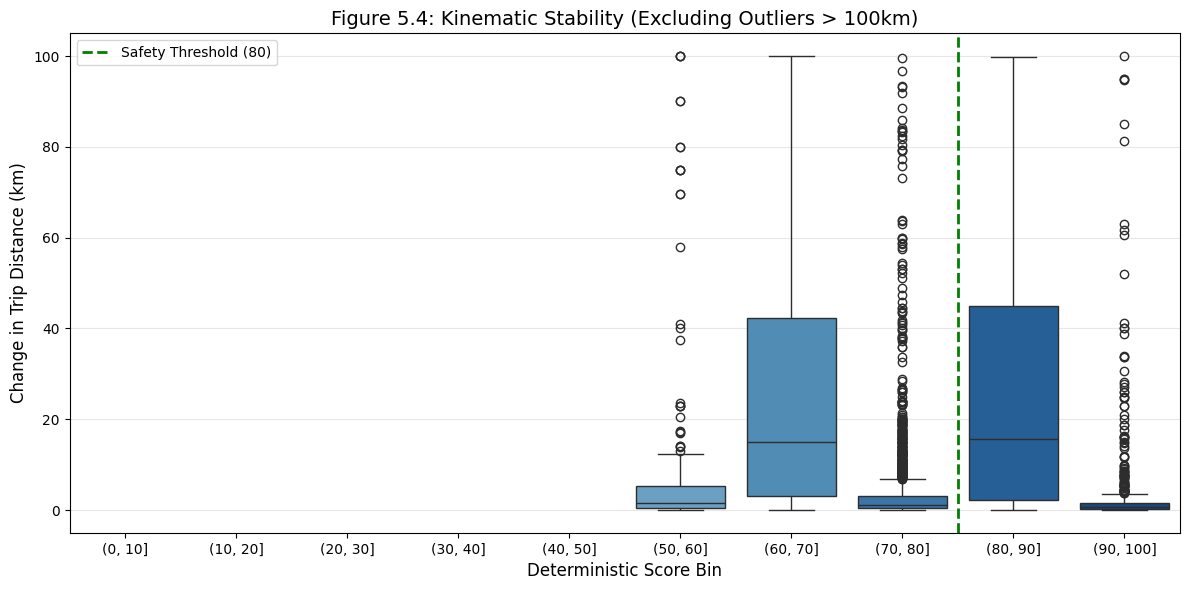


--- AVERAGE DISTANCE CHANGE (FILTERED) ---
det_score
(0, 20]            NaN
(20, 40]           NaN
(40, 60]      8.292140
(60, 80]      4.351509
(80, 100]    17.047824
Name: dist_delta, dtype: float64

--- VOLATILITY CHECK (>20km within Filtered) ---
det_score
(0, 20]        0
(20, 40]       0
(40, 60]      21
(60, 80]     132
(80, 100]    503
Name: SessionId, dtype: int64


C:\Users\nicoc\AppData\Local\Temp\ipykernel_17756\2629435581.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_clean.groupby(pd.cut(df_clean['det_score'], bins=range(0, 110, 20)))['dist_delta'].mean())
C:\Users\nicoc\AppData\Local\Temp\ipykernel_17756\2629435581.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(high_volatility.groupby(pd.cut(high_volatility['det_score'], bins=range(0, 110, 20)))['SessionId'].count())


In [20]:
# 1. EXTRACT SCORE
def extract_det_score(note):
    if pd.isna(note): return np.nan
    matches = re.findall(r'\((\d+)\)', str(note))
    if not matches: return np.nan
    return sum([int(m) for m in matches]) / len(matches)

df_plot = det_df[det_df['validation_status'] == 'corrected'].copy()
df_plot['det_score'] = df_plot['note_correction'].apply(extract_det_score)

# 2. CALCULATE DELTAS & FILTER OUTLIERS
# Absolute difference in km
df_plot['dist_delta'] = (df_plot['corrected_dist_km'] - df_plot['stagelength_raw']).abs()

# GLOBAL FILTER: Exclude "Teleportations" (>100km) to focus on regional stability
# We assume corrections >100km are either massive outliers or distinct edge cases (e.g., Cross-country Zero-Dist fix)
outlier_threshold = 100
df_clean = df_plot[df_plot['dist_delta'] <= outlier_threshold].copy()

print(f"Original Count: {len(df_plot)}")
print(f"Filtered Count (<= {outlier_threshold}km): {len(df_clean)}")
print(f"Outliers Removed: {len(df_plot) - len(df_clean)}")

# 3. GENERATE THE BOXPLOT (On Filtered Data)
plt.figure(figsize=(12, 6))

# Binning
df_clean['score_bin'] = pd.cut(df_clean['det_score'], bins=range(0, 110, 10))

sns.boxplot(x='score_bin', y='dist_delta', data=df_clean, palette="Blues")

# Annotations
plt.axvline(x=7.5, color='green', linestyle='--', linewidth=2, label='Safety Threshold (80)')
plt.title(f'Figure 5.4: Kinematic Stability (Excluding Outliers > {outlier_threshold}km)', fontsize=14)
plt.xlabel('Deterministic Score Bin', fontsize=12)
plt.ylabel('Change in Trip Distance (km)', fontsize=12)
plt.legend()
plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 4. PRINT STATISTICS (On Filtered Data)
print("\n--- AVERAGE DISTANCE CHANGE (FILTERED) ---")
print(df_clean.groupby(pd.cut(df_clean['det_score'], bins=range(0, 110, 20)))['dist_delta'].mean())

print("\n--- VOLATILITY CHECK (>20km within Filtered) ---")
high_volatility = df_clean[df_clean['dist_delta'] > 20]
print(high_volatility.groupby(pd.cut(high_volatility['det_score'], bins=range(0, 110, 20)))['SessionId'].count())

In [18]:
df_filtered['dist_delta'].describe()

count    5805.000000
mean        7.980482
std        17.834929
min         0.000000
25%         0.400000
50%         1.200000
75%         4.500000
max        99.900000
Name: dist_delta, dtype: float64

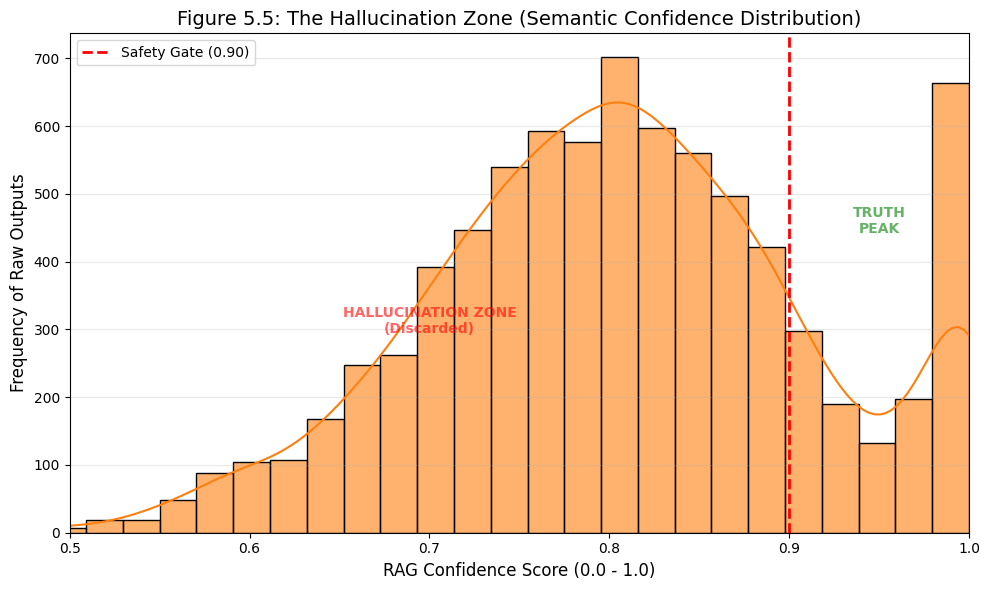

In [25]:
# Calculate Min Confidence (The "Chain Strength")
# We use the minimum of start/end because a trip is only valid if BOTH are good.
rag_df['min_conf'] = rag_df[['rag_start_conf', 'rag_end_conf']].min(axis=1)

# Filter for the "Corrected" verdict to see what the model actually produced
plot_df = rag_df[rag_df['llm_verdict'] == 'corrected'].copy()

# GENERATE PLOT
plt.figure(figsize=(10, 6))

# Histogram with kernel density estimate
sns.histplot(
    data=plot_df,
    x='min_conf',
    bins=30,
    color='#ff7f0e', # Standard Matplotlib Orange
    edgecolor='black',
    kde=True,
    alpha=0.6
)

# THRESHOLD LINE
plt.axvline(x=0.90, color='red', linestyle='--', linewidth=2, label='Safety Gate (0.90)')

# ANNOTATIONS
# Get y-axis limit to place text
y_max = plt.gca().get_ylim()[1]

plt.text(0.7, y_max*0.4, 'HALLUCINATION ZONE\n(Discarded)', 
         ha='center', color='red', fontweight='bold', alpha=0.6)

plt.text(0.95, y_max*0.6, 'TRUTH\nPEAK', 
         ha='center', color='green', fontweight='bold', alpha=0.6)

# FORMATTING
plt.title('Figure 5.5: The Hallucination Zone (Semantic Confidence Distribution)', fontsize=14)
plt.xlabel('RAG Confidence Score (0.0 - 1.0)', fontsize=12)
plt.ylabel('Frequency of Raw Outputs', fontsize=12)
plt.xlim(0.5, 1.0) # Zoom in on the relevant top half
plt.legend(loc='upper left')
plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Analyzing 1437 Safe Corrections and 6614 Discarded Hallucinations...

--- 1. TAXONOMY OF CORRECTIONS ---
fix_type
Syntactic (Typo)          1272
Hybrid (Format)            164
Semantic (Translation)       1
Name: count, dtype: int64
fix_type
Syntactic (Typo)          88.517745
Hybrid (Format)           11.412665
Semantic (Translation)     0.069589
Name: proportion, dtype: float64

--- 2. TOP 5 'FANTASY' LOCATIONS (In Discarded Data) ---
rag_start_address
Slusevej 4, 4140 Borup                75
Magnoliavej 53, 2000 Frederiksberg    15
Tofthøjvej 61, 4130 Viby Sjælland     12
Højbjerg Huse 1D, 8840 Rødkærsbro     11
Højbjerg Huse 7, 8840 Rødkærsbro       9
Name: count, dtype: int64


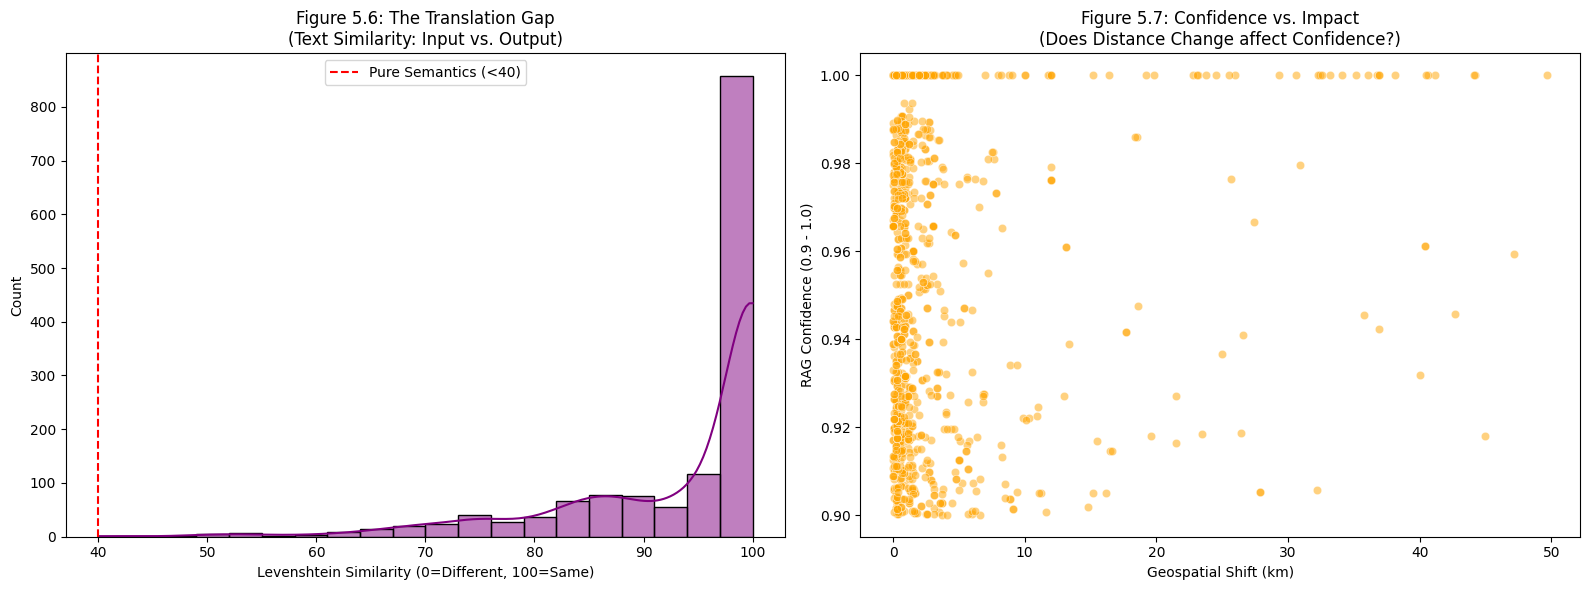

In [24]:
import Levenshtein

# Filter for the "Safe" subset (Verdict = Corrected AND Conf >= 0.9)
rag_df['min_conf'] = rag_df[['rag_start_conf', 'rag_end_conf']].min(axis=1)
safe_rag = rag_df[(rag_df['llm_verdict'] == 'corrected') & (rag_df['min_conf'] >= 0.90)].copy()
discarded_rag = rag_df[(rag_df['llm_verdict'] == 'corrected') & (rag_df['min_conf'] < 0.90)].copy()

print(f"Analyzing {len(safe_rag)} Safe Corrections and {len(discarded_rag)} Discarded Hallucinations...")

# --- ANALYSIS 1: SEMANTIC VS. LEXICAL (The "Translation" Factor) ---
# Calculate Levenshtein Ratio between Input and Output
# Ratio 100 = Identical, Ratio 0 = Completely Different
def calc_similarity(row):
    # focus on the start address for simplicity
    input_text = str(row['startTripText_raw'])
    output_text = str(row['rag_start_address'])
    return Levenshtein.ratio(input_text.lower(), output_text.lower()) * 100

safe_rag['text_similarity'] = safe_rag.apply(calc_similarity, axis=1)

# Categorize
# > 80: Typos (Spelling corrections)
# 40-80: Formatting/Partial (e.g., "Main St" -> "Main Street, NY")
# < 40: Pure Semantic (e.g., "Home" -> "5th Avenue")
def categorize_fix(score):
    if score > 80: return 'Syntactic (Typo)'
    elif score > 40: return 'Hybrid (Format)'
    else: return 'Semantic (Translation)'

safe_rag['fix_type'] = safe_rag['text_similarity'].apply(categorize_fix)

print("\n--- 1. TAXONOMY OF CORRECTIONS ---")
print(safe_rag['fix_type'].value_counts())
print(safe_rag['fix_type'].value_counts(normalize=True) * 100)

# --- ANALYSIS 2: HALLUCINATION BIAS ---
# What addresses does the model love to invent when it doesn't know the answer?
print("\n--- 2. TOP 5 'FANTASY' LOCATIONS (In Discarded Data) ---")
print(discarded_rag['rag_start_address'].value_counts().head(5))

# --- GRAPHS ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graph A: The "Translation Gap"
# Shows that RAG fixes things that look NOTHING like the input
sns.histplot(safe_rag['text_similarity'], bins=20, ax=axes[0], color='purple', kde=True)
axes[0].set_title('Figure 5.6: The Translation Gap\n(Text Similarity: Input vs. Output)', fontsize=12)
axes[0].set_xlabel('Levenshtein Similarity (0=Different, 100=Same)')
axes[0].axvline(x=40, color='red', linestyle='--', label='Pure Semantics (<40)')
axes[0].legend()

# Graph B: Confidence vs. Distance
# Does the model lose confidence when moving points far away?
safe_rag['dist_delta'] = (safe_rag['corrected_dist_km'] - safe_rag['stagelength_raw']).abs()
# Filter extreme outliers for plotting
plot_delta = safe_rag[safe_rag['dist_delta'] < 50]

sns.scatterplot(x='dist_delta', y='min_conf', data=plot_delta, ax=axes[1], alpha=0.5, color='orange')
axes[1].set_title('Figure 5.7: Confidence vs. Impact\n(Does Distance Change affect Confidence?)', fontsize=12)
axes[1].set_xlabel('Geospatial Shift (km)')
axes[1].set_ylabel('RAG Confidence (0.9 - 1.0)')

plt.tight_layout()
plt.show()

In [26]:
# --- 1. DEFINE THE SETS ---
# DET found it if status is 'hard_wrong' (the input list) AND it fixed it ('corrected')
# actually, we want to compare what they *Fixed* successfully.
# Let's look at the SAFE corrections only.

det_safe = det_df[(det_df['validation_status'] == 'corrected') & 
                  (det_df['confidence_score'] >= 80)].index

rag_safe = rag_df[(rag_df['llm_verdict'] == 'corrected') & 
                  (rag_df['min_conf'] >= 0.90)].index

# Convert to sets
set_det = set(det_safe)
set_rag = set(rag_safe)

# --- 2. CALCULATE OVERLAP ---
intersection = set_det.intersection(set_rag)
det_only = set_det - set_rag
rag_only = set_rag - set_det

# --- 3. ANALYZE THE "RAG ONLY" (The Value Add) ---
# We want to know: Are these just random things, or the "Zero Distance" fixes?
rag_only_df = rag_df.loc[list(rag_only)]

# Check for Zero Distance (stagelength_raw approx 0)
zero_dist_count = len(rag_only_df[rag_only_df['stagelength_raw'] < 0.05])
avg_dist_change = (rag_only_df['corrected_dist_km'] - rag_only_df['stagelength_raw']).abs().mean()

print("--- DATA FOR SECTION 5.4 (The Overlap) ---")
print(f"1. Consensus (Found by Both): {len(intersection)}")
print(f"2. DET Exclusive (RAG missed/unsafe): {len(det_only)}")
print(f"3. RAG Exclusive (DET missed/unsafe): {len(rag_only)}")
print("-" * 30)
print(f"Analysis of RAG Exclusive ({len(rag_only)} rows):")
print(f"   - Zero-Distance Artifacts: {zero_dist_count}")
print(f"   - Avg Distance Change: {avg_dist_change:.2f} km")

--- DATA FOR SECTION 5.4 (The Overlap) ---
1. Consensus (Found by Both): 37
2. DET Exclusive (RAG missed/unsafe): 6227
3. RAG Exclusive (DET missed/unsafe): 1400
------------------------------
Analysis of RAG Exclusive (1400 rows):
   - Zero-Distance Artifacts: 121
   - Avg Distance Change: 12.72 km


In [29]:
# --- DEFINITIONS OF "FIXED" ---

# 1. DET FIX:
# Must be marked 'corrected' AND have a High Score (>= 80)
# We assume 'validation_status' == 'corrected' implies it was originally an error.
def get_det_score(note):
    if pd.isna(note): return 0
    matches = re.findall(r'\((\d+)\)', str(note))
    if not matches: return 0
    return sum([int(m) for m in matches]) / len(matches)

# Calculate scores if not present
det_df['score'] = det_df['note_correction'].apply(get_det_score)

# Filter: Status is Corrected AND Score is Safe
det_safe_rows = det_df[
    (det_df['validation_status'] == 'corrected') & 
    (det_df['score'] >= 80)
]
det_indices = set(det_safe_rows.index)

# 2. RAG FIX:
# Must be marked 'corrected' AND have High Confidence (>= 0.90)
rag_df['min_conf'] = rag_df[['rag_start_conf', 'rag_end_conf']].min(axis=1)

rag_safe_rows = rag_df[
    (rag_df['llm_verdict'] == 'corrected') & 
    (rag_df['min_conf'] >= 0.90)
]
rag_indices = set(rag_safe_rows.index)

# --- RECALCULATE OVERLAP ---
intersection = det_indices.intersection(rag_indices)
det_only = det_indices - rag_indices
rag_only = rag_indices - det_indices

print("--- RECALCULATED VENN DATA (STRICT) ---")
print(f"1. Consensus (Both Fixed): {len(intersection)}")
print(f"2. DET Exclusive: {len(det_only)}")
print(f"3. RAG Exclusive: {len(rag_only)}")
print("-" * 30)

# Sanity Check on the "Big Number"
print(f"Total DET 'Corrected' rows in file: {len(det_df[det_df['validation_status'] == 'corrected'])}")
print(f"Total RAG 'Corrected' rows in file: {len(rag_df[rag_df['llm_verdict'] == 'corrected'])}")

--- RECALCULATED VENN DATA (STRICT) ---
1. Consensus (Both Fixed): 37
2. DET Exclusive: 6102
3. RAG Exclusive: 1400
------------------------------
Total DET 'Corrected' rows in file: 7341
Total RAG 'Corrected' rows in file: 8051


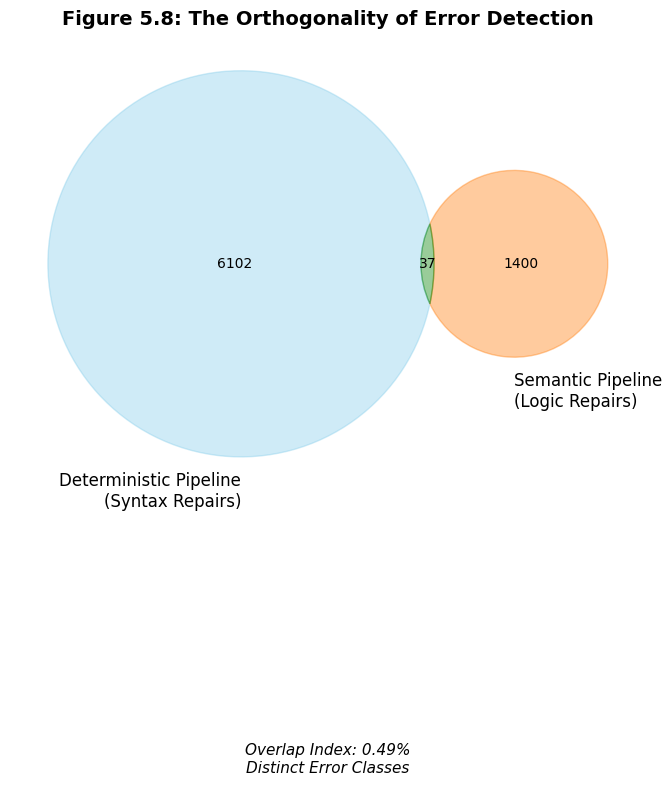

In [30]:
plt.figure(figsize=(10, 6))

# Venn Diagram
venn = venn2(subsets=(6102, 1400, 37), 
             set_labels=('Deterministic Pipeline\n(Syntax Repairs)', 'Semantic Pipeline\n(Logic Repairs)'))

# Customizing colors
venn.get_patch_by_id('10').set_color('skyblue') # DET
venn.get_patch_by_id('01').set_color('#ff7f0e') # RAG
venn.get_patch_by_id('11').set_color('green')   # Overlap

plt.title('Figure 5.8: The Orthogonality of Error Detection', fontsize=14, fontweight='bold')

# Add annotation regarding the near-zero overlap
plt.text(0.5, -0.6, 
         f"Overlap Index: {37/(6102+1400+37):.2%}\nDistinct Error Classes", 
         ha='center', fontsize=11, style='italic', transform=plt.gca().transAxes)

plt.show()

--- SIMPLIFIED BEHAVIORAL ANALYSIS (PERCENTAGES) ---
Bias_Category  Under (-20%+)  Slight Under  Accurate (+/-5%)  Slight Over  \
Mode_Name                                                                   
Bicycle            19.101124     10.861423         13.670412    18.539326   
Car/Van            21.164163     14.431330         24.222103    19.876609   
Walk               13.576642      6.861314          7.737226    16.642336   

Bias_Category  Over (+20-50%)  Extreme (+50%+)  
Mode_Name                                       
Bicycle             20.224719        17.602996  
Car/Van             11.775751         8.530043  
Walk                26.277372        28.905109  


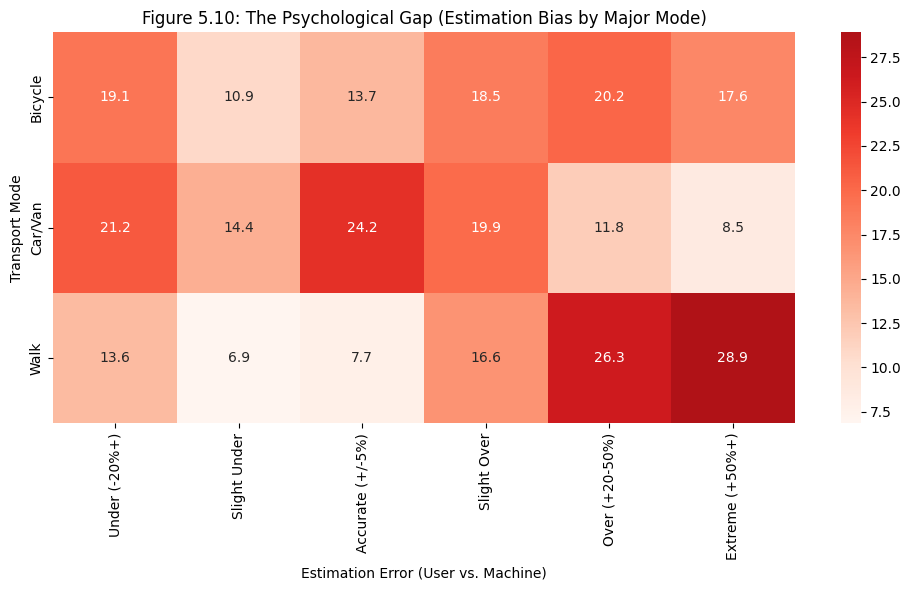

In [56]:
# --- 1. PREPARE DATA ---
def extract_det_score(note):
    if pd.isna(note): return 0
    matches = re.findall(r'\((\d+)\)', str(note))
    if not matches: return 0
    return sum([int(m) for m in matches]) / len(matches)

det_df['score'] = det_df['note_correction'].apply(extract_det_score)
det_safe = det_df[(det_df['validation_status'] == 'corrected') & (det_df['score'] >= 80)].copy()

rag_df['min_conf'] = rag_df[['rag_start_conf', 'rag_end_conf']].min(axis=1)
rag_safe = rag_df[(rag_df['llm_verdict'] == 'corrected') & (rag_df['min_conf'] >= 0.90)].copy()

cols = ['transportmiddel', 'stagelength_raw', 'corrected_dist_km'] 
combined = pd.concat([det_safe[cols], rag_safe[cols]])

# --- 2. MAP ONLY THE "BIG THREE" ---
# 1=Walk, 2=Bike, 11=Car, 12=Van
# We group 11+12 into "Car/Van"
tu_modes_simplified = {
    1: 'Walk',
    2: 'Bicycle',
    11: 'Car/Van',
    12: 'Car/Van'
}

# Filter and Map
combined = combined[combined['transportmiddel'].isin(tu_modes_simplified.keys())].copy()
combined['Mode_Name'] = combined['transportmiddel'].map(tu_modes_simplified)

# --- 3. CALCULATE BIAS ---
combined['bias_pct'] = (combined['stagelength_raw'] - combined['corrected_dist_km']) / combined['corrected_dist_km']

# Filter extremes (-80% to +150%)
plot_data = combined[(combined['bias_pct'] > -0.8) & (combined['bias_pct'] < 1.5)].copy()

# Categorize
bins = [-np.inf, -0.2, -0.05, 0.05, 0.2, 0.5, np.inf]
labels = ['Under (-20%+)','Slight Under','Accurate (+/-5%)', 'Slight Over', 'Over (+20-50%)', 'Extreme (+50%+)']
plot_data['Bias_Category'] = pd.cut(plot_data['bias_pct'], bins=bins, labels=labels)

# --- 4. GENERATE HEATMAP (PERCENTAGES) ---
# Normalize by index (row) -> sum of row = 100%
heatmap_data = pd.crosstab(plot_data['Mode_Name'], plot_data['Bias_Category'], normalize='index') * 100

print("--- SIMPLIFIED BEHAVIORAL ANALYSIS (PERCENTAGES) ---")
print(heatmap_data)

# --- 5. PLOT ---
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="Reds", center=20)
plt.title('Figure 5.10: The Psychological Gap (Estimation Bias by Major Mode)')
plt.ylabel('Transport Mode')
plt.xlabel('Estimation Error (User vs. Machine)')
plt.tight_layout()
plt.show()

--- DET PIPELINE (Percentages) ---
Bias_Category  Under (-20%+)  Slight Under  Accurate (+/-5%)  Slight Over  \
Mode_Name                                                                   
Bicycle            20.098039     11.764706         12.254902    20.833333   
Car/Van            22.235797     14.294441         23.579719    19.670128   
Walk               22.352941      9.411765          6.666667    14.509804   

Bias_Category  Over (+20-50%)  Extreme (+50%+)  
Mode_Name                                       
Bicycle             20.833333        14.215686  
Car/Van             11.973122         8.246793  
Walk                22.745098        24.313725  

--- RAG PIPELINE (Percentages) ---
Bias_Category  Under (-20%+)  Slight Under  Accurate (+/-5%)  Slight Over  \
Mode_Name                                                                   
Bicycle            15.873016      7.936508         18.253968    11.111111   
Car/Van            13.436123     15.418502         28.854626    21.

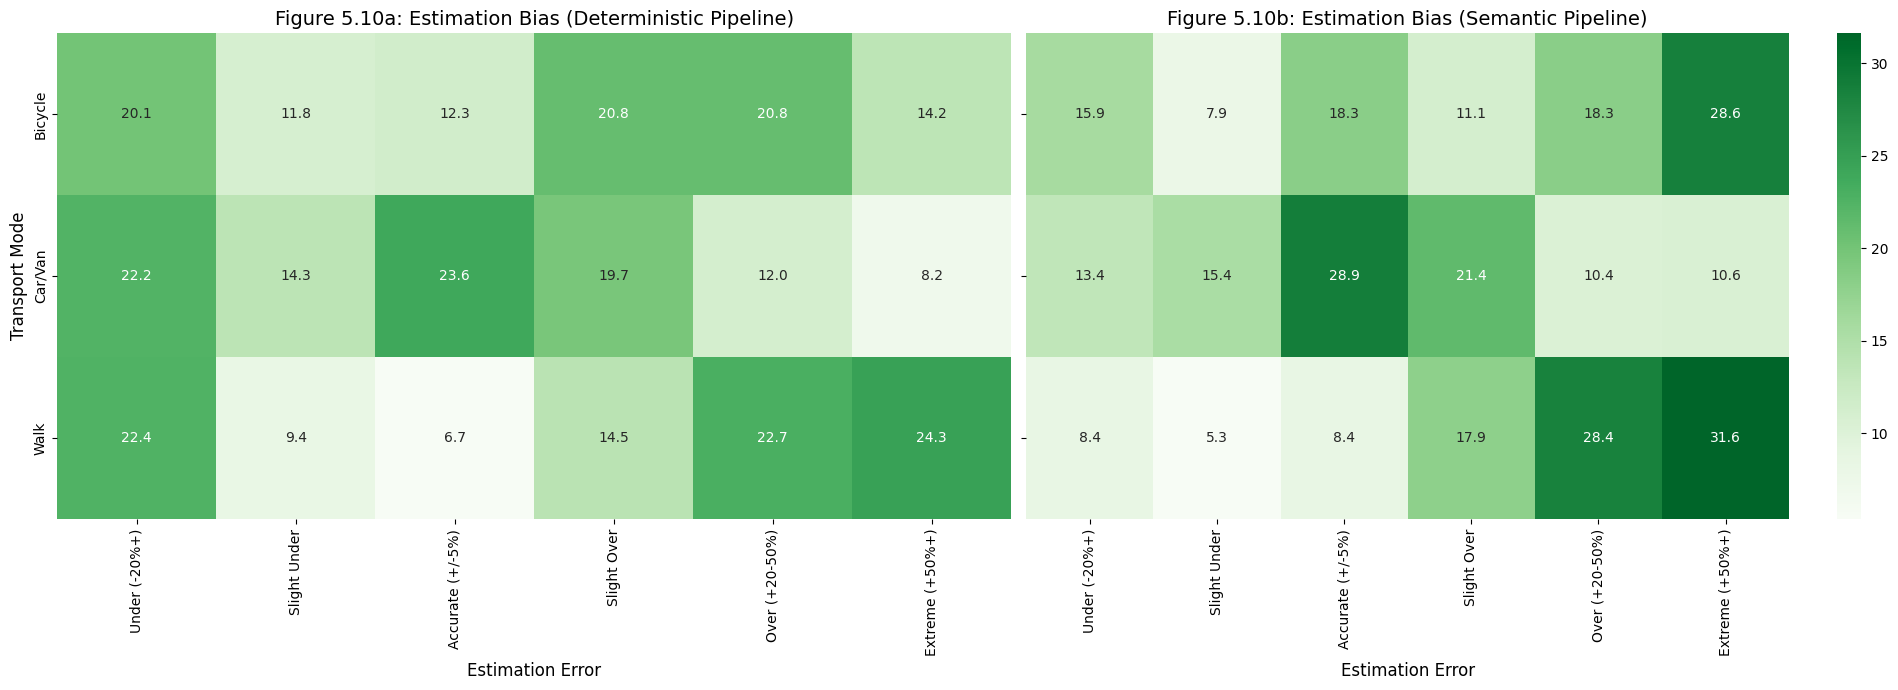

In [44]:
# --- DEFINITIONS ---
tu_modes_simplified = {
    1: 'Walk',
    2: 'Bicycle',
    11: 'Car/Van',
    12: 'Car/Van'
}

bins = [-np.inf, -0.2, -0.05, 0.05, 0.2, 0.5, np.inf]
labels = ['Under (-20%+)','Slight Under','Accurate (+/-5%)', 'Slight Over', 'Over (+20-50%)', 'Extreme (+50%+)']

def process_pipeline(df, name):
    # 1. Filter Safe Rows
    if name == 'DET':
        def get_score(n):
            if pd.isna(n): return 0
            matches = re.findall(r'\((\d+)\)', str(n))
            if not matches: return 0
            return sum([int(m) for m in matches]) / len(matches)
        
        df['score'] = df['note_correction'].apply(get_score)
        safe = df[(df['validation_status'] == 'corrected') & (df['score'] >= 80)].copy()
    else: # RAG
        df['min_conf'] = df[['rag_start_conf', 'rag_end_conf']].min(axis=1)
        safe = df[(df['llm_verdict'] == 'corrected') & (df['min_conf'] >= 0.90)].copy()

    # 2. Filter & Map Modes
    # Ensure we check both column naming conventions just in case
    col = 'transportmiddel' if 'transportmiddel' in safe.columns else 'TransportMode'
    
    safe = safe[safe[col].isin(tu_modes_simplified.keys())].copy()
    safe['Mode_Name'] = safe[col].map(tu_modes_simplified)

    # 3. Calculate Bias
    safe['bias_pct'] = (safe['stagelength_raw'] - safe['corrected_dist_km']) / safe['corrected_dist_km']
    
    # Filter Extremes
    safe = safe[(safe['bias_pct'] > -0.8) & (safe['bias_pct'] < 1.5)]
    
    # 4. Binning
    safe['Bias_Category'] = pd.cut(safe['bias_pct'], bins=bins, labels=labels)
    
    # 5. Crosstab (Normalized %)
    return pd.crosstab(safe['Mode_Name'], safe['Bias_Category'], normalize='index') * 100

# --- EXECUTE ---
heatmap_det = process_pipeline(det_df, 'DET')
heatmap_rag = process_pipeline(rag_df, 'RAG')

print("--- DET PIPELINE (Percentages) ---")
print(heatmap_det)
print("\n--- RAG PIPELINE (Percentages) ---")
print(heatmap_rag)

# --- PLOTTING ---
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)

# Plot DET
sns.heatmap(heatmap_det, annot=True, fmt=".1f", cmap="Greens", center=20, ax=axes[0], cbar=False)
axes[0].set_title('Figure 5.10a: Estimation Bias (Deterministic Pipeline)', fontsize=14)
axes[0].set_ylabel('Transport Mode', fontsize=12)
axes[0].set_xlabel('Estimation Error', fontsize=12)

# Plot RAG
sns.heatmap(heatmap_rag, annot=True, fmt=".1f", cmap="Greens", center=20, ax=axes[1], cbar=True)
axes[1].set_title('Figure 5.10b: Estimation Bias (Semantic Pipeline)', fontsize=14)
axes[1].set_ylabel('') # Hide Y label for second plot
axes[1].set_xlabel('Estimation Error', fontsize=12)

plt.tight_layout()
plt.show()

--- 1. DET DISTANCE ERROR ---
Bias_Status      Underestimated   Accurate  Overestimated
Category                                                 
Short (<2km)          28.182807  20.348205      51.468988
Medium (2-10km)       21.677419  51.612903      26.709677
Long (>10km)          57.650430  34.555874       7.793696

--- 2. RAG DISTANCE ERROR ---
Bias_Status      Underestimated   Accurate  Overestimated
Category                                                 
Short (<2km)          11.599297  14.586995      73.813708
Medium (2-10km)       20.975610  53.902439      25.121951
Long (>10km)          40.285714  52.000000       7.714286

--- 3. DET TIME ERROR ---
Bias_Status      Underestimated   Accurate  Overestimated
Category                                                 
Short (<15m)          17.639485  32.317597      50.042918
Medium (15-60m)       32.306831  47.928331      19.764838
Long (>60m)           89.050701   9.007551       1.941748

--- 4. RAG TIME ERROR ---
Bias_Status    

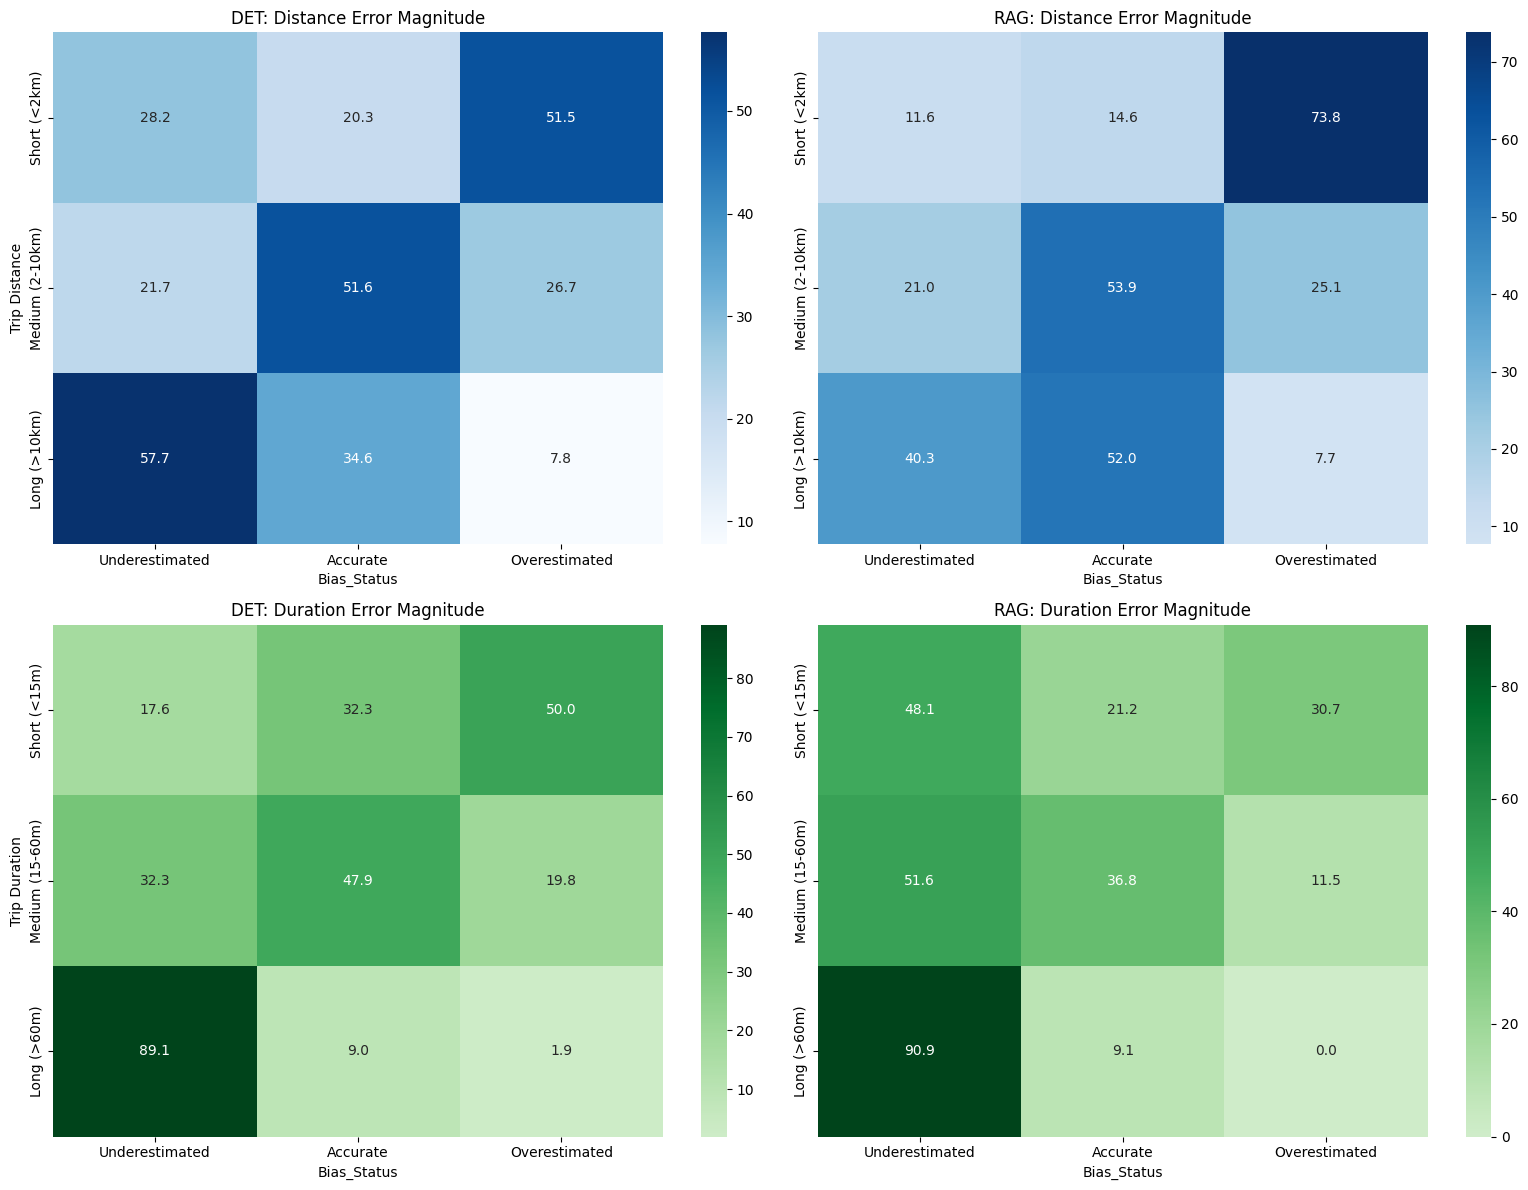

In [43]:
# --- 1. PRE-PROCESSING & FILTERING ---

# Filter DET Safe
def extract_det_score(note):
    if pd.isna(note): return 0
    matches = re.findall(r'\((\d+)\)', str(note))
    if not matches: return 0
    return sum([int(m) for m in matches]) / len(matches)

det_df['score'] = det_df['note_correction'].apply(extract_det_score)
det_safe = det_df[(det_df['validation_status'] == 'corrected') & (det_df['score'] >= 80)].copy()

# Filter RAG Safe
rag_df['min_conf'] = rag_df[['rag_start_conf', 'rag_end_conf']].min(axis=1)
rag_safe = rag_df[(rag_df['llm_verdict'] == 'corrected') & (rag_df['min_conf'] >= 0.90)].copy()

# Ensure numeric types
cols_dist = ['stagelength_raw', 'corrected_dist_km']
# Assuming time columns exist. If 'corrected_time_min' is missing, we infer from OSRM duration usually in seconds
# Adjust column names below if your CSV has different names for time!
cols_time = ['stagedurationmin_raw', 'corrected_time_min'] 

# --- 2. MATRIX GENERATION FUNCTION ---

def generate_matrix(df, mode='distance'):
    # Select Columns & Calculate Bias
    if mode == 'distance':
        # Check if cols exist
        if 'corrected_dist_km' not in df.columns: return None
        data = df[['stagelength_raw', 'corrected_dist_km']].dropna().copy()
        
        # Bias: (User - Machine) / Machine
        data['bias'] = (data['stagelength_raw'] - data['corrected_dist_km']) / data['corrected_dist_km']
        
        # Y-Axis: Trip Size Categories (User Defined)
        data['Category'] = pd.cut(
            data['corrected_dist_km'], 
            bins=[0, 2, 10, 9999], 
            labels=['Short (<2km)', 'Medium (2-10km)', 'Long (>10km)']
        )
        
    elif mode == 'time':
        # Check if cols exist (Handling potential missing col)
        # We try to use 'corrected_time_min' (or 'osrm_duration' / 60 if needed)
        time_col = 'corrected_time_min'
        if time_col not in df.columns and 'osrm_duration' in df.columns:
            df['corrected_time_min'] = df['osrm_duration'] / 60
            
        if 'corrected_time_min' not in df.columns: return None
            
        data = df[['stagedurationmin_raw', 'corrected_time_min']].dropna().copy()
        
        # Bias
        data['bias'] = (data['stagedurationmin_raw'] - data['corrected_time_min']) / data['corrected_time_min']
        
        # Y-Axis: Duration Categories (User Defined)
        data['Category'] = pd.cut(
            data['corrected_time_min'],
            bins=[0, 15, 60, 9999],
            labels=['Short (<15m)', 'Medium (15-60m)', 'Long (>60m)']
        )

    # X-Axis: Bias Categories (Simple 3-way split)
    # Under (< -20%), Accurate (+/- 20%), Over (> +20%)
    bins_bias = [-np.inf, -0.2, 0.2, np.inf]
    labels_bias = ['Underestimated', 'Accurate', 'Overestimated']
    
    data['Bias_Status'] = pd.cut(data['bias'], bins=bins_bias, labels=labels_bias)
    
    # Create Matrix (Normalized %)
    matrix = pd.crosstab(data['Category'], data['Bias_Status'], normalize='index') * 100
    return matrix

# --- 3. GENERATE THE 4 MATRICES ---

mat_det_dist = generate_matrix(det_safe, 'distance')
mat_rag_dist = generate_matrix(rag_safe, 'distance')
mat_det_time = generate_matrix(det_safe, 'time')
mat_rag_time = generate_matrix(rag_safe, 'time')

# --- 4. PRINT TABLES ---

print("--- 1. DET DISTANCE ERROR ---")
print(mat_det_dist)
print("\n--- 2. RAG DISTANCE ERROR ---")
print(mat_rag_dist)
print("\n--- 3. DET TIME ERROR ---")
print(mat_det_time)
print("\n--- 4. RAG TIME ERROR ---")
print(mat_rag_time)

# --- 5. PLOT 2x2 GRID ---

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distances Top Row
if mat_det_dist is not None:
    sns.heatmap(mat_det_dist, annot=True, fmt=".1f", cmap="Blues", center=33, ax=axes[0,0])
    axes[0,0].set_title('DET: Distance Error Magnitude')
    axes[0,0].set_ylabel('Trip Distance')

if mat_rag_dist is not None:
    sns.heatmap(mat_rag_dist, annot=True, fmt=".1f", cmap="Blues", center=33, ax=axes[0,1])
    axes[0,1].set_title('RAG: Distance Error Magnitude')
    axes[0,1].set_ylabel('')

# Times Bottom Row
if mat_det_time is not None:
    sns.heatmap(mat_det_time, annot=True, fmt=".1f", cmap="Greens", center=33, ax=axes[1,0])
    axes[1,0].set_title('DET: Duration Error Magnitude')
    axes[1,0].set_ylabel('Trip Duration')

if mat_rag_time is not None:
    sns.heatmap(mat_rag_time, annot=True, fmt=".1f", cmap="Greens", center=33, ax=axes[1,1])
    axes[1,1].set_title('RAG: Duration Error Magnitude')
    axes[1,1].set_ylabel('')

plt.tight_layout()
plt.show()

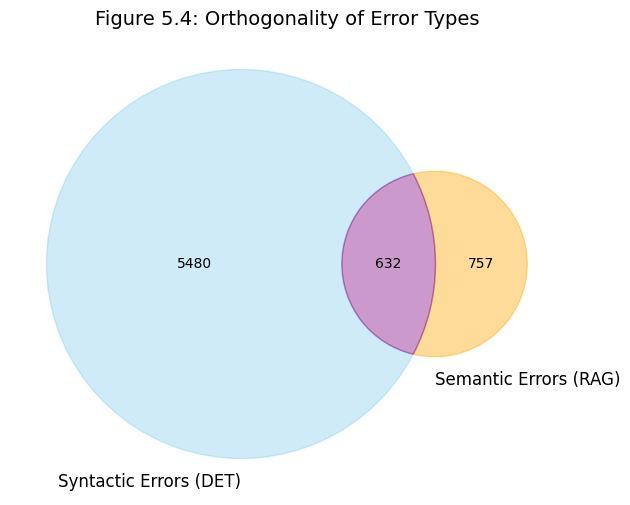

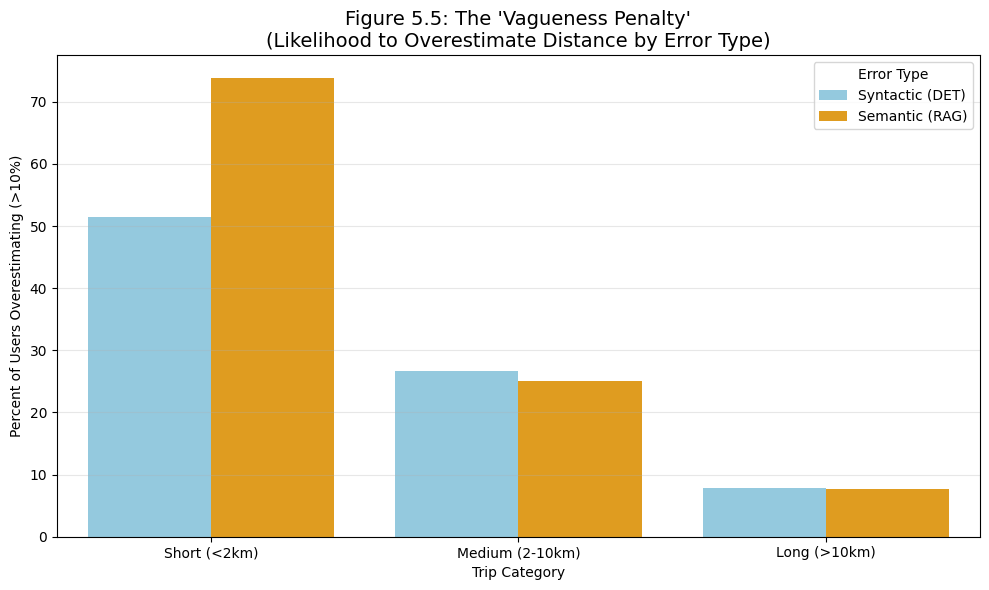

In [54]:
# --- 1. IDENTIFY THE UNIQUE IDs FOR VENN ---
# DET Safe IDs
def extract_det_score(note):
    if pd.isna(note): return 0
    matches = re.findall(r'\((\d+)\)', str(note))
    if not matches: return 0
    return sum([int(m) for m in matches]) / len(matches)

det_df['score'] = det_df['note_correction'].apply(extract_det_score)
det_ids = set(det_df[(det_df['validation_status'] == 'corrected') & (det_df['score'] >= 80)]['turid'])

# RAG Safe IDs
rag_df['min_conf'] = rag_df[['rag_start_conf', 'rag_end_conf']].min(axis=1)
rag_ids = set(rag_df[(rag_df['llm_verdict'] == 'corrected') & (rag_df['min_conf'] >= 0.90)]['turid'])

# --- 2. PLOT VENN DIAGRAM ---
plt.figure(figsize=(8, 6))
v = venn2([det_ids, rag_ids], ('Syntactic Errors (DET)', 'Semantic Errors (RAG)'))
try:
    v.get_patch_by_id('10').set_color('skyblue') # DET Only
    v.get_patch_by_id('01').set_color('orange')  # RAG Only
    v.get_patch_by_id('11').set_color('purple')  # Overlap
except:
    pass
plt.title("Figure 5.4: Orthogonality of Error Types", fontsize=14)
plt.show()

# --- 3. PREPARE COMPARATIVE BIAS DATA ---
# (Using the explicit percentages you provided in previous turns)
data = {
    'Error Type': ['Syntactic (DET)', 'Syntactic (DET)', 'Syntactic (DET)', 
                   'Semantic (RAG)', 'Semantic (RAG)', 'Semantic (RAG)'],
    'Trip Length': ['Short (<2km)', 'Medium (2-10km)', 'Long (>10km)', 
                    'Short (<2km)', 'Medium (2-10km)', 'Long (>10km)'],
    'Distance Overestimation %': [51.5, 26.7, 7.8, 73.8, 25.1, 7.7]
}
df_comp = pd.DataFrame(data)

# --- 4. PLOT COMPARATIVE BAR CHART ---
plt.figure(figsize=(10, 6))
sns.barplot(x='Trip Length', y='Distance Overestimation %', hue='Error Type', 
            data=df_comp, palette=['skyblue', 'orange'])

plt.title("Figure 5.5: The 'Vagueness Penalty'\n(Likelihood to Overestimate Distance by Error Type)", fontsize=14)
plt.ylabel("Percent of Users Overestimating (>10%)")
plt.xlabel("Trip Category")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

--- FAILURE TAXONOMY (PERCENTAGES) ---
                          DET Discards  RAG Discards
Error_Type                                          
Complex / Unclassified       93.935789     86.396523
Semantic Concept (Logic)      5.917345     11.958406
Ambiguity / Privacy           0.132920      1.513026
Noise (<3 chars)              0.013946      0.132046


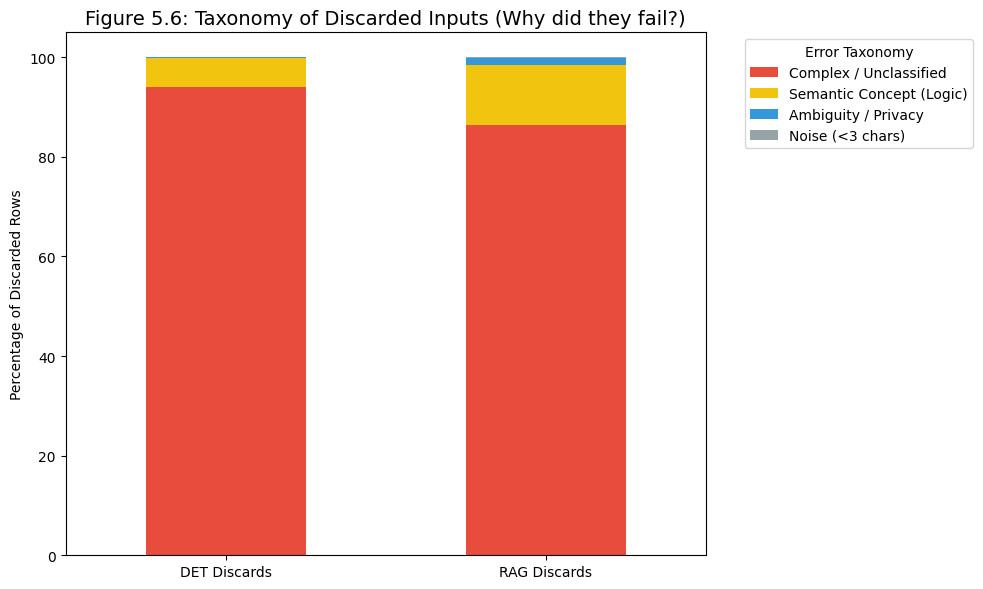

In [52]:
# --- 1. FILTER FOR DISCARDED ROWS ONLY ---

# DET Discards (Score < 80)
def extract_det_score(note):
    if pd.isna(note): return 0
    matches = re.findall(r'\((\d+)\)', str(note))
    if not matches: return 0
    return sum([int(m) for m in matches]) / len(matches)

det_df['score'] = det_df['note_correction'].apply(extract_det_score)
det_fail = det_df[det_df['score'] < 80].copy()

# RAG Discards (Conf < 0.90)
rag_df['min_conf'] = rag_df[['rag_start_conf', 'rag_end_conf']].min(axis=1)
rag_fail = rag_df[rag_df['min_conf'] < 0.90].copy()

# --- 2. DEFINE TAXONOMY FUNCTIONS ---

def categorize_error(text):
    text = str(text).lower().strip()
    
    # Category 1: Noise (Too short)
    if len(text) < 3:
        return 'Noise (<3 chars)'
    
    # Category 2: Privacy / Refusal (Ambiguity)
    ambiguous_keywords = ['privat', 'hemmelig', 'ved ikke', 'ukendt', 'unknown', 'private', 'don\'t know']
    if any(k in text for k in ambiguous_keywords):
        return 'Ambiguity / Privacy'
        
    # Category 3: Semantic Concepts (Logic)
    # Common Danish descriptors found in surveys
    semantic_keywords = ['arbejde', 'job', 'hjem', 'skole', 'gymnasium', 'universitet', 
                         'work', 'home', 'school', 'butik', 'center', 'station']
    if any(k in text for k in semantic_keywords):
        return 'Semantic Concept (Logic)'
    
    # Category 4: The Complex Tail
    return 'Complex / Unclassified'

# --- 3. APPLY TAXONOMY ---
# We use the raw text column. Adjust 'startTripText_raw' / 'tiladrtext_raw' as needed.
# For simplicity, let's assume we are checking the Destination text (often the problem).
col_name = 'tiladrtext_raw' 

det_fail['Error_Type'] = det_fail[col_name].apply(categorize_error)
rag_fail['Error_Type'] = rag_fail[col_name].apply(categorize_error)

# --- 4. CALCULATE STATISTICS ---

det_stats = det_fail['Error_Type'].value_counts(normalize=True) * 100
rag_stats = rag_fail['Error_Type'].value_counts(normalize=True) * 100

# Combine for Plotting
comp_df = pd.DataFrame({
    'DET Discards': det_stats,
    'RAG Discards': rag_stats
}).fillna(0)

print("--- FAILURE TAXONOMY (PERCENTAGES) ---")
print(comp_df)

# --- 5. PLOT STACKED BAR CHART ---
plt.figure(figsize=(10, 6))
comp_df.T.plot(kind='bar', stacked=True, color=['#e74c3c', '#f1c40f', '#3498db', '#95a5a6'], ax=plt.gca())

plt.title('Figure 5.6: Taxonomy of Discarded Inputs (Why did they fail?)', fontsize=14)
plt.ylabel('Percentage of Discarded Rows')
plt.xticks(rotation=0)
plt.legend(title='Error Taxonomy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [53]:
# --- 1. RE-CREATE THE 'FAIL' SUBSETS ---
# (Using your Logic)
def extract_det_score(note):
    if pd.isna(note): return 0
    matches = re.findall(r'\((\d+)\)', str(note))
    if not matches: return 0
    return sum([int(m) for m in matches]) / len(matches)

det_df['score'] = det_df['note_correction'].apply(extract_det_score)
det_fail = det_df[det_df['score'] < 80].copy()

rag_df['min_conf'] = rag_df[['rag_start_conf', 'rag_end_conf']].min(axis=1)
rag_fail = rag_df[rag_df['min_conf'] < 0.90].copy()

# --- 2. DEFINE THE SURGICAL CLASSIFIER ---

def analyze_structure(text):
    text = str(text).lower().strip()
    
    # Feature 1: Word Count (Is it a sentence?)
    words = text.split()
    if len(words) >= 5:
        return 'Narrative Description (>5 words)'
    
    # Feature 2: Address Markers (Is it trying to be an address?)
    # Common Danish street suffixes
    address_suffixes = ['vej', 'gade', 'alle', 'allé', 'plads', 'torv', 'boulevard', 'stræde']
    has_suffix = any(s in text for s in address_suffixes)
    has_digit = any(char.isdigit() for char in text)
    
    if has_suffix and has_digit:
        return 'Malformed Specific Address (Street + Number)'
    elif has_suffix:
        return 'Generic Street Name (No Number)'
        
    # Feature 3: The "Stub" (Short, non-address)
    return 'Vague Stub (1-4 words, No Address markers)'

# --- 3. APPLY TO THE "COMPLEX" BUCKET ---

# We only want to analyze the ones that fell into "Complex" before
# But to be safe, let's just apply this to ALL failures to see the real structure
det_fail['Structural_Type'] = det_fail['tiladrtext_raw'].apply(analyze_structure)
rag_fail['Structural_Type'] = rag_fail['tiladrtext_raw'].apply(analyze_structure)

# --- 4. PRINT RESULTS ---
print("--- DET FAILURE STRUCTURE ---")
print(det_fail['Structural_Type'].value_counts(normalize=True) * 100)

print("\n--- RAG FAILURE STRUCTURE ---")
print(rag_fail['Structural_Type'].value_counts(normalize=True) * 100)

--- DET FAILURE STRUCTURE ---
Structural_Type
Narrative Description (>5 words)                61.880232
Malformed Specific Address (Street + Number)    27.828258
Vague Stub (1-4 words, No Address markers)      10.259260
Generic Street Name (No Number)                  0.032249
Name: proportion, dtype: float64

--- RAG FAILURE STRUCTURE ---
Structural_Type
Narrative Description (>5 words)                79.410470
Malformed Specific Address (Street + Number)    13.849688
Vague Stub (1-4 words, No Address markers)       6.474375
Generic Street Name (No Number)                  0.265467
Name: proportion, dtype: float64


C:\Users\nicoc\AppData\Local\Temp\ipykernel_17756\3661245515.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Narrative\n(>5 words)', 'Malformed\nAddress', 'Vague\nStub', 'Generic\nStreet'])


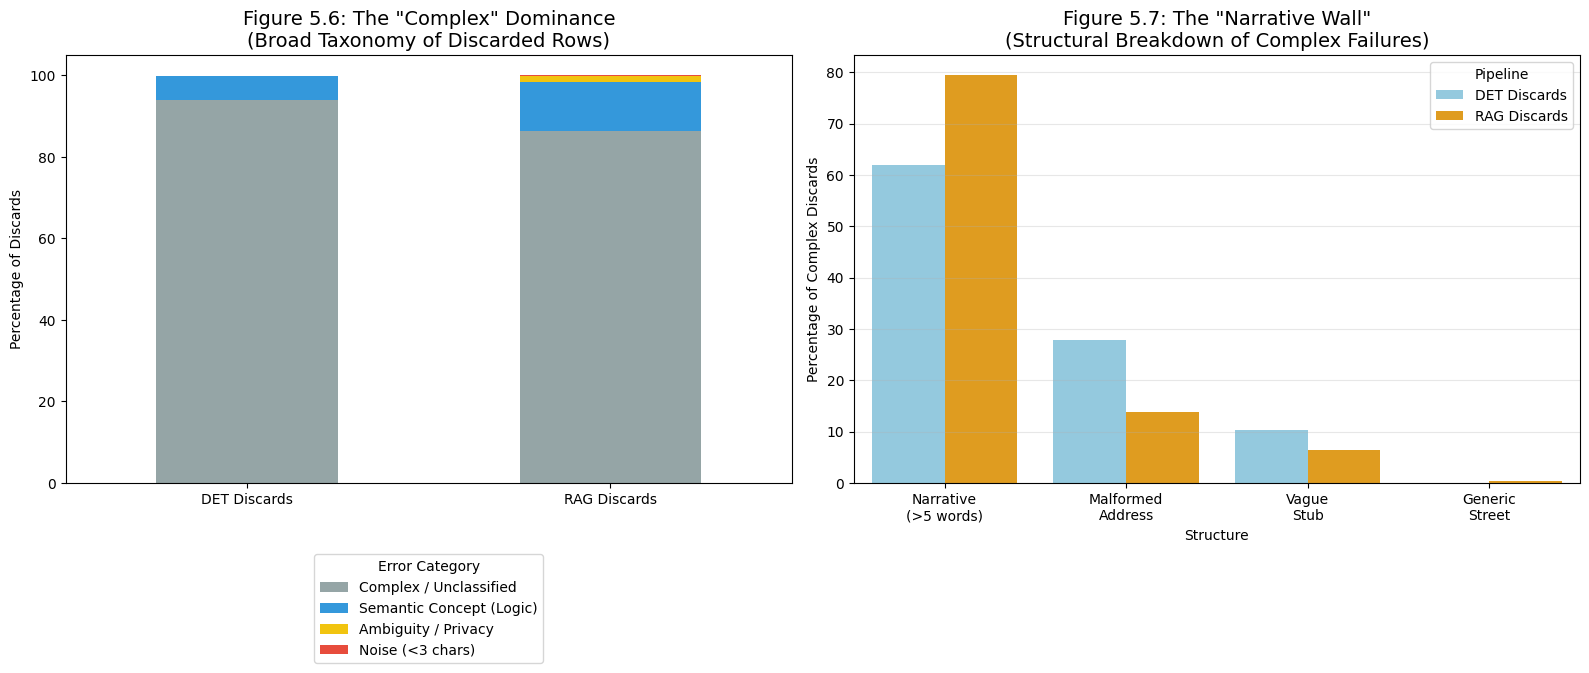

In [55]:
# --- DATA ENTRY (Using your exact results) ---
# Table 1: Broad Taxonomy
broad_data = {
    'Category': ['Complex / Unclassified', 'Semantic Concept (Logic)', 'Ambiguity / Privacy', 'Noise (<3 chars)'],
    'DET Discards': [93.9, 5.9, 0.1, 0.01],
    'RAG Discards': [86.4, 12.0, 1.5, 0.1]
}
df_broad = pd.DataFrame(broad_data)

# Table 2: Structural Taxonomy
struct_data = {
    'Structure': ['Narrative (>5 words)', 'Malformed Address', 'Vague Stub', 'Generic Street'],
    'DET Discards': [61.9, 27.8, 10.3, 0.03],
    'RAG Discards': [79.4, 13.8, 6.5, 0.3]
}
df_struct = pd.DataFrame(struct_data)

# --- PLOTTING ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Broad Taxonomy (Stacked Bar)
# Pivot for stacking
df_broad_plot = df_broad.set_index('Category').T
df_broad_plot.plot(kind='bar', stacked=True, ax=axes[0], color=['#95a5a6', '#3498db', '#f1c40f', '#e74c3c'])
axes[0].set_title('Figure 5.6: The "Complex" Dominance\n(Broad Taxonomy of Discarded Rows)', fontsize=14)
axes[0].set_ylabel('Percentage of Discards')
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(title='Error Category', bbox_to_anchor=(0.5, -0.15), loc='upper center')

# Plot 2: Structural Breakdown (Grouped Bar)
# Melt for Seaborn
df_struct_melt = df_struct.melt(id_vars='Structure', var_name='Pipeline', value_name='Percentage')
sns.barplot(x='Structure', y='Percentage', hue='Pipeline', data=df_struct_melt, ax=axes[1], palette=['skyblue', 'orange'])
axes[1].set_title('Figure 5.7: The "Narrative Wall"\n(Structural Breakdown of Complex Failures)', fontsize=14)
axes[1].set_ylabel('Percentage of Complex Discards')
axes[1].set_xticklabels(['Narrative\n(>5 words)', 'Malformed\nAddress', 'Vague\nStub', 'Generic\nStreet'])
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend(title='Pipeline', loc='upper right')

plt.tight_layout()
plt.show()

--- AGGREGATED DISTANCE BIAS (DET + RAG) ---
Dist_Status      Accurate  Overestimated  Underestimated
Dist_Cat                                                
Short (<2km)         19.2           64.3            16.5
Medium (2-10km)      54.8           26.3            19.0
Long (>10km)         38.4            8.0            53.6

--- AGGREGATED TIME BIAS (DET + RAG) ---
Time_Status      Accurate  Overestimated  Underestimated
Time_Cat                                                
Short (<15m)         26.3           49.5            24.2
Medium (15-60m)      47.5           18.0            34.5
Long (>60m)           9.2            1.8            89.1


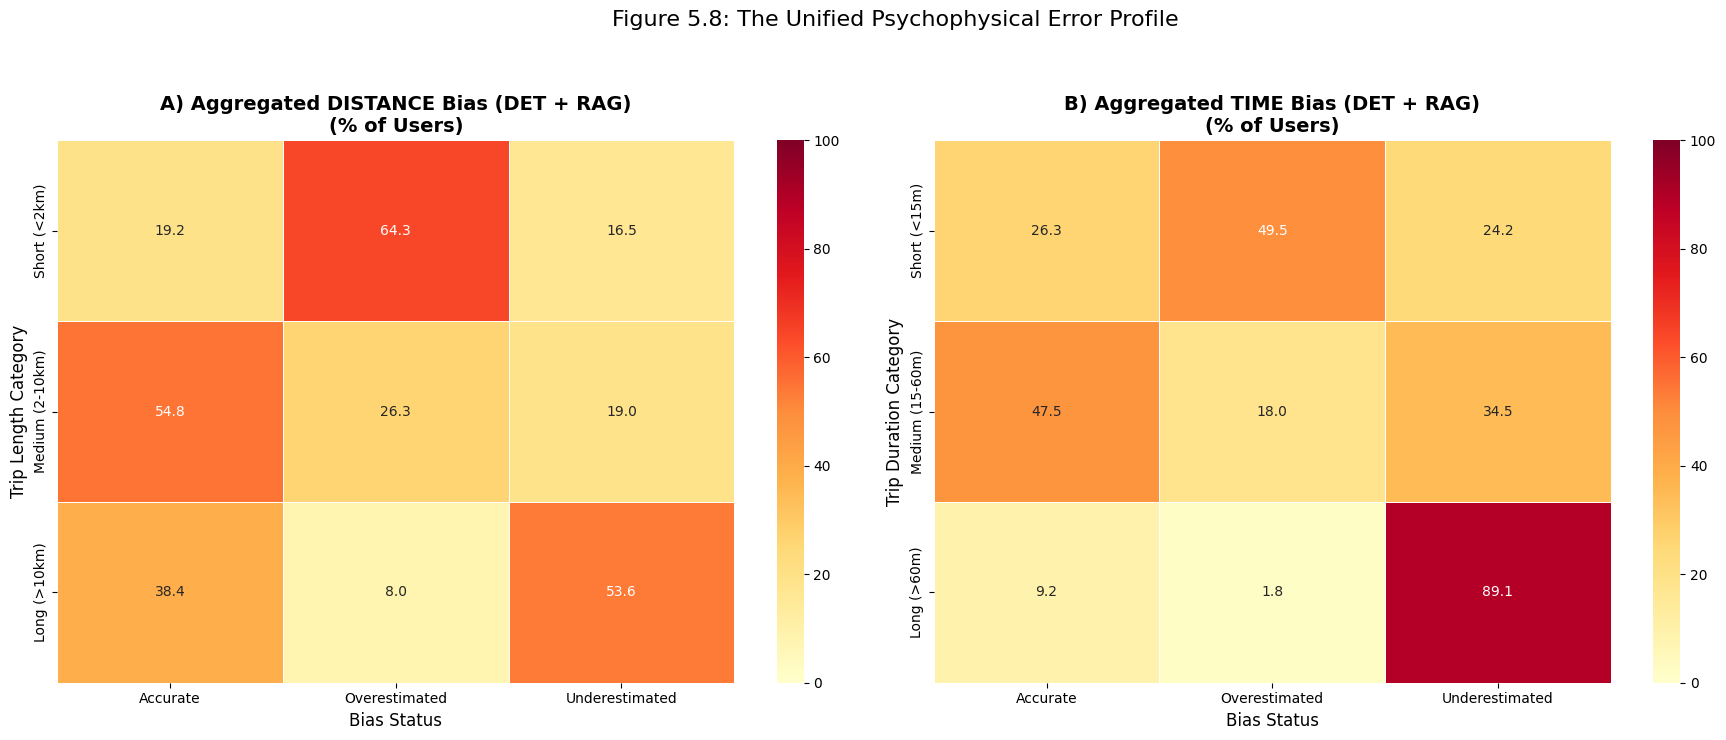

In [62]:
# A) Filter DET (Syntax Layer)
# Ensure we extracted the score previously or do it here
det_df['det_score'] = det_df['note_correction'].apply(lambda x: int(re.search(r'\((\d+)\)', str(x)).group(1)) if re.search(r'\((\d+)\)', str(x)) else 0)
det_safe = det_df[(det_df['validation_status'] == 'corrected') & (det_df['det_score'] >= 80)].copy()
det_safe['Pipeline'] = 'DET'

# B) Filter RAG (Semantic Layer)
rag_df['min_conf'] = rag_df[['rag_start_conf', 'rag_end_conf']].min(axis=1)
rag_safe = rag_df[(rag_df['llm_verdict'] == 'corrected') & (rag_df['min_conf'] >= 0.90)].copy()
rag_safe['Pipeline'] = 'RAG'

# C) Concatenate (The Combined Dataset)
# We only keep the columns needed for bias calculation to avoid mismatch errors
cols = ['turid', 'stagelength_raw', 'corrected_dist_km', 'stagedurationmin_raw', 'corrected_time_min', 'Pipeline']
# Note: Ensure columns exist in both. If 'stagedurationmin_raw' is missing in one, handle accordingly.
combined_df = pd.concat([det_safe[cols], rag_safe[cols]], ignore_index=True)

# --- 2. CALCULATE AGGREGATED BIAS ---

def generate_bias_matrix(df, dist_col='corrected_dist_km', time_col='corrected_time_min'):
    # --- Distance Bias ---
    # Calc Error: (Raw - Corrected) / Corrected
    df['dist_err_pct'] = ((df['stagelength_raw'] - df[dist_col]) / df[dist_col])
    
    # Classify Length
    conds = [
        (df[dist_col] < 2),
        (df[dist_col] >= 2) & (df[dist_col] <= 10),
        (df[dist_col] > 10)
    ]
    cats = ['Short (<2km)', 'Medium (2-10km)', 'Long (>10km)']
    df['Dist_Cat'] = np.select(conds, cats, default='Unknown')
    
    # Classify Bias
    # Over (>20%), Under (<-20%), Accurate (Between)
    bias_conds = [
        (df['dist_err_pct'] < -0.20),
        (df['dist_err_pct'].abs() <= 0.20),
        (df['dist_err_pct'] > 0.20)
    ]
    bias_names = ['Underestimated', 'Accurate', 'Overestimated']
    df['Dist_Status'] = np.select(bias_conds, bias_names, default='Accurate')
    
    # --- Time Bias ---
    if time_col in df.columns:
        df['time_err_pct'] = ((df['stagedurationmin_raw'] - df[time_col]) / df[time_col])
        
        t_conds = [
            (df[time_col] < 15),
            (df[time_col] >= 15) & (df[time_col] <= 60),
            (df[time_col] > 60)
        ]
        t_cats = ['Short (<15m)', 'Medium (15-60m)', 'Long (>60m)']
        df['Time_Cat'] = np.select(t_conds, t_cats, default='Unknown')
        
        df['Time_Status'] = np.select(
            [(df['time_err_pct'] < -0.20), (df['time_err_pct'].abs() <= 0.20), (df['time_err_pct'] > 0.20)],
            bias_names, default='Accurate'
        )
    
    return df

# Run Calculation
final_df = generate_bias_matrix(combined_df)

# --- 3. CREATE MATRICES ---

# Matrix 1: DISTANCE (Aggregated)
dist_matrix = pd.crosstab(final_df['Dist_Cat'], final_df['Dist_Status'], normalize='index') * 100
dist_matrix = dist_matrix.reindex(['Short (<2km)', 'Medium (2-10km)', 'Long (>10km)'])
print("--- AGGREGATED DISTANCE BIAS (DET + RAG) ---")
print(dist_matrix.round(1))

# Matrix 2: TIME (Aggregated)
if 'Time_Status' in final_df.columns:
    time_matrix = pd.crosstab(final_df['Time_Cat'], final_df['Time_Status'], normalize='index') * 100
    time_matrix = time_matrix.reindex(['Short (<15m)', 'Medium (15-60m)', 'Long (>60m)'])
    print("\n--- AGGREGATED TIME BIAS (DET + RAG) ---")
    print(time_matrix.round(1))

    # --- 4. VISUALIZE THE AGGREGATED MATRIXES ---

# Set up the figure for side-by-side plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot A: Distance Bias Heatmap
sns.heatmap(dist_matrix, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=.5, ax=axes[0], vmin=0, vmax=100)
axes[0].set_title('A) Aggregated DISTANCE Bias (DET + RAG)\n(% of Users)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Trip Length Category', fontsize=12)
axes[0].set_xlabel('Bias Status', fontsize=12)

# Plot B: Time Bias Heatmap
if 'Time_Status' in final_df.columns:
    sns.heatmap(time_matrix, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=.5, ax=axes[1], vmin=0, vmax=100)
    axes[1].set_title('B) Aggregated TIME Bias (DET + RAG)\n(% of Users)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Trip Duration Category', fontsize=12)
    axes[1].set_xlabel('Bias Status', fontsize=12)

# Overall Title
plt.suptitle('Figure 5.8: The Unified Psychophysical Error Profile', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()